# **CLASSIFICATION DES ICEBERGS PAR IMAGERIE SATELLITAIRE**

In [1]:
import sys
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)

In [2]:
def get_data():
    train_set = pd.read_json("processed/train.json")
    return train_set
train_set =get_data()
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1604 non-null   object
 1   band_1      1604 non-null   object
 2   band_2      1604 non-null   object
 3   inc_angle   1604 non-null   object
 4   is_iceberg  1604 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 62.8+ KB


In [3]:
train_set.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


**Informations sur la base de données :**
- La base de données d'entrainement contient 1604 images des icebergs prises par un satellite situé à plus de 600 km de la surface de la terre.
- Les images sont prises selon deux polarisations ( Verticale et Horizontale ) 
- `id` l'identifiant de l'image
- `band_1`, `band_2`: les données d'images aplaties (75x75), band_1 pour une polarisation HH , band_2 pour une polarisation HV
- `inc_angle` l'angle d'incidence
- `is_iceberg` la cible : 1 si l'image représente un iceberg et 0 sinon

Dans un premier temps, on prend pas en considération l'effet de l'angle et on prend chaque polarisation comme une image indépendante et on construit notre nouvelle dataset

In [4]:
df2=train_set.iloc[:,[1,4]]
df3=train_set.iloc[:,[2,4]]
df2.rename(columns={"band_1": "image"}, inplace=True)
df3.rename(columns={"band_2": "image"}, inplace=True)
df=pd.concat([df2,df3], ignore_index=True)
df=df.sample(frac=1).reset_index(drop=True)
df

,image,is_iceberg
0,"[-12.458082, -12.930975, -15.697103, -12.28735...",1
1,"[-26.958382, -23.329922, -21.434137, -21.43407...",0
2,"[-20.635405, -20.635405, -21.256159, -22.10018...",1
3,"[-26.32168, -23.399189, -24.738194, -26.037075...",0
4,"[-25.714788, -24.691803, -27.859119, -25.99075...",0
...,...,...
3203,"[-21.318993, -20.05341, -20.05341, -19.907478,...",1
3204,"[-17.987705, -20.123066, -20.123066, -14.76816...",1
3205,"[-23.065128, -24.533783, -25.248173, -27.50233...",1
3206,"[-18.56296, -17.359287, -18.922569, -21.140553...",1


(array([0, 1]), [Text(0, 0, 'bateau'), Text(1, 0, 'iceberg')])

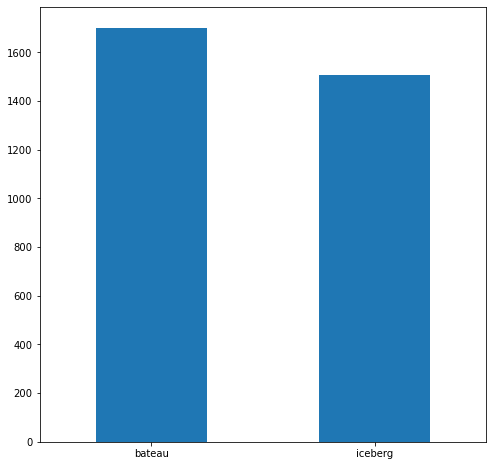

In [5]:
plo, axe = plt.subplots(figsize=(8,8))
is_iceberg = df["is_iceberg"]
is_iceberg = is_iceberg.replace({0:"bateau", 1:"iceberg"}).value_counts()
is_iceberg.plot(kind="bar",ax=axe)
plt.xticks(rotation=0)

On remarque qu'il existe pas une grande différence entre le nombre des icebergs et des bateaux dans la base de données donc on peut dire que la base de données est ( balanced )

In [6]:
np.array(df["image"][0]).reshape(75,75)

array([[-1.2458082e+01, -1.2930975e+01, -1.5697103e+01, -1.2287355e+01,
        -1.2574119e+01, -2.0190084e+01, -1.3560959e+01, -1.3177769e+01,
        -1.4527201e+01, -1.4674423e+01, -9.4706220e+00, -9.5526390e+00,
        -1.0648103e+01, -1.1584106e+01, -1.3759569e+01, -1.4749351e+01,
        -1.6668926e+01, -1.7450279e+01, -1.4455108e+01, -1.3304395e+01,
        -1.3304395e+01, -1.4100679e+01, -1.3304543e+01, -1.0981968e+01,
        -1.5370626e+01, -1.5132642e+01, -1.2811815e+01, -1.6039249e+01,
        -1.4312128e+01, -1.3432722e+01, -1.2232838e+01, -1.2232838e+01,
        -1.5371071e+01, -1.4825664e+01, -1.1178933e+01, -1.3117208e+01,
        -1.3117208e+01, -1.0556686e+01, -8.8812200e+00, -1.1533805e+01,
        -1.1482330e+01, -9.9762170e+00, -1.0063077e+01, -1.3242631e+01,
        -1.3896088e+01, -1.4384653e+01, -1.2813076e+01, -1.2813076e+01,
        -1.1958111e+01, -1.2346755e+01, -1.4529718e+01, -1.2290317e+01,
        -1.1431828e+01, -9.5964200e+00, -1.1130628e+01, -1.65783

# Normalisation des images

In [7]:
def normalise_image(img):
    arr = np.array(img)
    arr = (arr - np.min(arr))/(np.max(arr)- np.min(arr)) 
    return arr
df["image"] =df["image"].apply(normalise_image)
df.head()

,image,is_iceberg
0,"[0.37367924821653203, 0.35425425381429115, 0.2...",1
1,"[0.3524615738659869, 0.4865356848360121, 0.556...",0
2,"[0.5316728280734389, 0.5316728280734389, 0.504...",1
3,"[0.5870483116590425, 0.7668099823177941, 0.684...",0
4,"[0.3916291863292645, 0.43863447585737547, 0.29...",0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3208 entries, 0 to 3207
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       3208 non-null   object
 1   is_iceberg  3208 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 50.2+ KB


### Echantillon des Images pour visualisation

In [9]:
#sampling icerbergs and ships
sample_ice=df[df["is_iceberg"]==1].sample(n=16)
sample_ship=df[df["is_iceberg"]==0].sample(n=16)
sample_ice.index=[i for i in range(16)]
sample_ship.index=[i for i in range(16)]


## Images des Icebergs

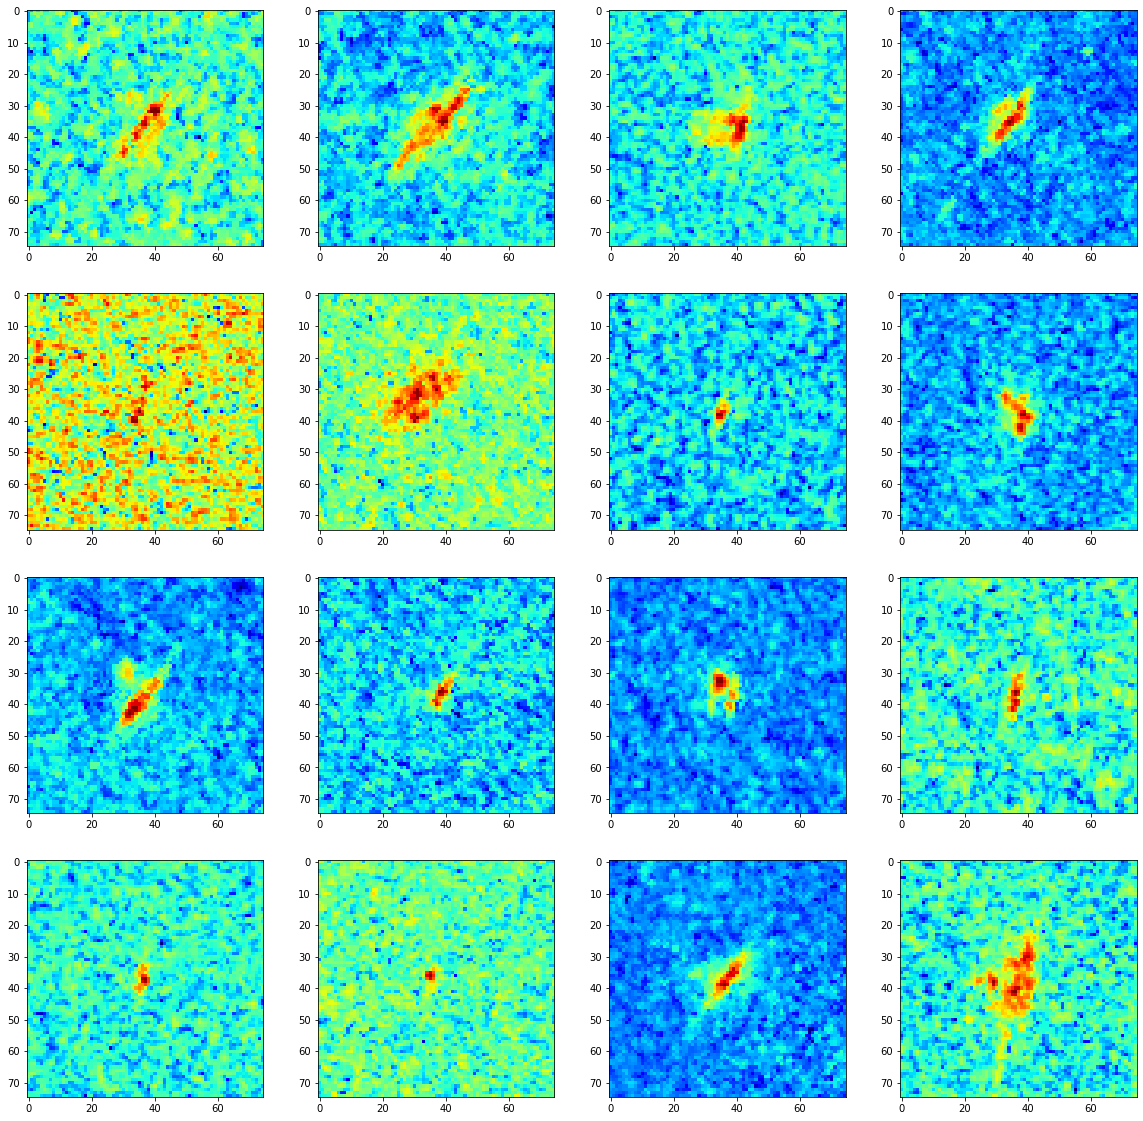

In [10]:
fig=plt.figure(figsize=(20,20))
for i in range(16):
    ax=fig.add_subplot(4,4,i+1)
    arr=sample_ice["image"][i]
    ax.imshow(arr.reshape(75,75),interpolation='none',cmap='jet')


## Images des Bateaux

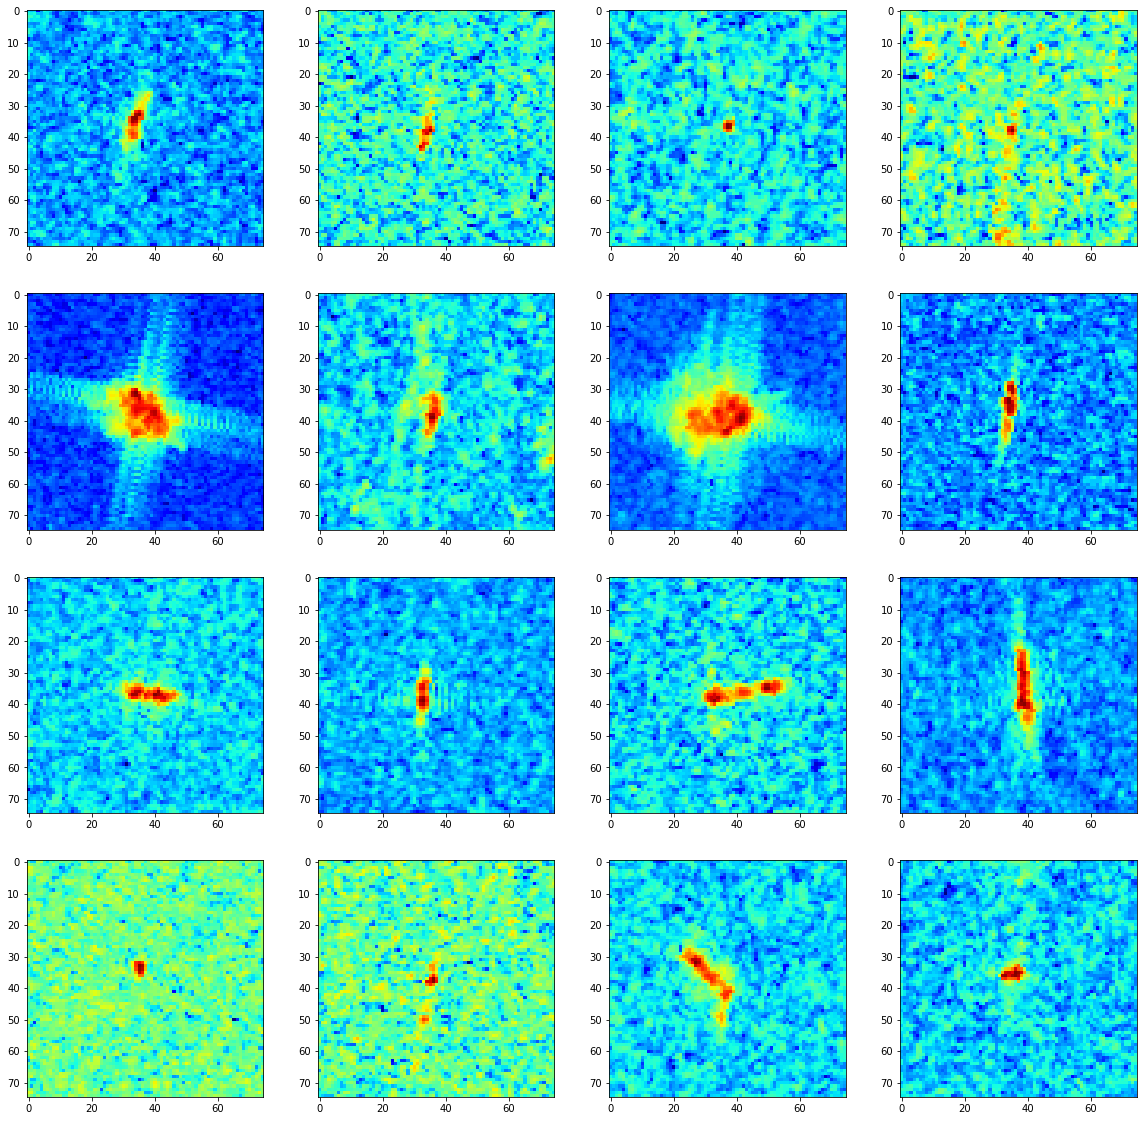

In [11]:
fig=plt.figure(figsize=(20,20))
for i in range(16):
    ax=fig.add_subplot(4,4,i+1)
    arr=sample_ship["image"][i]
    ax.imshow(arr.reshape(75,75),interpolation='none',cmap='jet')

On essaie maintenant quelques algorithmes de classification pour voir comment ils performent sur les données initialement

In [12]:
from sklearn.model_selection import train_test_split
X= pd.DataFrame(df["image"].to_list())
Y = df["is_iceberg"]
X_train , X_test , Y_train, Y_test= train_test_split(X, Y)

In [13]:
Y_train.value_counts()

0    1292
1    1114
Name: is_iceberg, dtype: int64

In [14]:
Y_test.value_counts()

0    410
1    392
Name: is_iceberg, dtype: int64

## **Logistic Regression**


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, accuracy_score
lg = LogisticRegression()
lg.fit(X_train, Y_train)
lg_predictions = lg.predict(X_test)
print(f" --> Logistic Regression training accuracy : {lg.score(X_train, Y_train)}")
print(f" --> Logistic Regression test accuracy     : {lg.score(X_test, Y_test)}")
print(f" --> Logistic Regression precision         : {precision_score(Y_test, lg_predictions)}")
print(f" --> Logistic Regression recall            : {recall_score(Y_test, lg_predictions)}")


 --> Logistic Regression training accuracy : 0.9979218620116376
 --> Logistic Regression test accuracy     : 0.6733167082294265
 --> Logistic Regression precision         : 0.6737967914438503
 --> Logistic Regression recall            : 0.6428571428571429


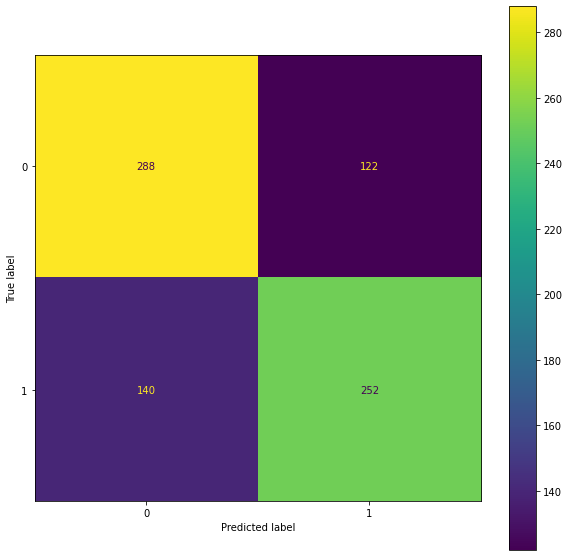

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(lg, X_test, Y_test, ax=ax)
plt.show()

## **K-NN**

In [27]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)
pred_knn = knn.predict(X_test)
print(f" --> K-NN training accuracy : {knn.score(X_train, Y_train)}")
print(f" --> K-NN test accuracy     : {knn.score(X_test, Y_test)}")
print(f" --> K-NN precision         : {precision_score(Y_test, pred_knn)}")
print(f" --> K-NN recall            : {recall_score(Y_test, pred_knn)}")

 --> K-NN training accuracy : 0.8283458021612635
 --> K-NN test accuracy     : 0.7206982543640897
 --> K-NN precision         : 0.7372881355932204
 --> K-NN recall            : 0.6658163265306123


- Pour un agorithme assez simple, K-NN a réalisé de bonne performance 82% sur la base d'entrainement et 72% pour le test; 73% precision ; 66% recall

Matrice de confusion (KNN)

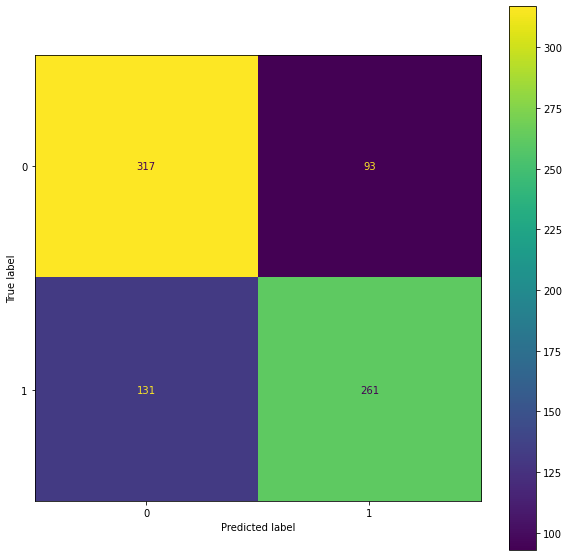

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(knn, X_test, Y_test, ax=ax)
plt.show()

## **SVM**

In [29]:
from sklearn import svm
kernels = ["linear", "poly", "rbf"]
for kernel_ in kernels :
    print(f" ----- Kernel : {kernel_} -----")
    clf = svm.SVC(kernel=kernel_, C =3.3)
    clf.fit(X_train, Y_train)
    pred_svm = clf.predict(X_test)
    print(f" --> training accuracy using : {clf.score(X_train, Y_train)}")
    print(f" --> test accuracy           : {clf.score(X_test, Y_test)}") 
    print(f" --> Precision               : {precision_score(Y_test, pred_svm)}")
    print(f" --> Recall                  : {recall_score(Y_test,pred_svm )}")
    print()

 ----- Kernel : linear -----
 --> training accuracy using : 1.0
 --> test accuracy           : 0.6683291770573566
 --> Precision               : 0.6693548387096774
 --> Recall                  : 0.6352040816326531

 ----- Kernel : poly -----
 --> training accuracy using : 1.0
 --> test accuracy           : 0.7256857855361596
 --> Precision               : 0.7362637362637363
 --> Recall                  : 0.6836734693877551

 ----- Kernel : rbf -----
 --> training accuracy using : 0.9962593516209476
 --> test accuracy           : 0.7605985037406484
 --> Precision               : 0.7564102564102564
 --> Recall                  : 0.7525510204081632



Matrice de confusion de test set (SVM)

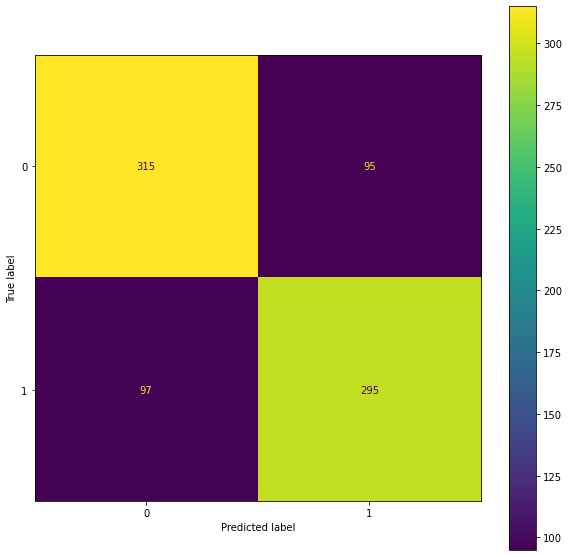

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(clf, X_test, Y_test, ax=ax)
plt.show()

- les résultats de SVM sont intéressants pour une première tentative, mais il est clairement surajusté.
- On essaie de le régulariser

**GridSearch for Hyperparameter Tuning**

In [31]:
from sklearn.model_selection import RandomizedSearchCV
clf_svm_rbf = RandomizedSearchCV(svm.SVC(kernel='rbf'), {
    'C':[3.1,3.2,3.3,3.4,3.5],
    'gamma':[0.003,0.0035,0.004]
}, cv=5)
clf_svm_rbf.fit(X_train,Y_train)
pd.DataFrame(clf_svm_rbf.cv_results_)

In [22]:
clf_svm_rbf.best_params_

{'gamma': 0.003, 'C': 3.3}

In [27]:
optimized_clf = svm.SVC(kernel="rbf", gamma=0.006, C=3.3, probability=True)
optimized_clf.fit(X_train, Y_train)
op_pred= optimized_clf.predict(X_test)
print("train :", optimized_clf.score(X_train,Y_train))
print("test :", optimized_clf.score(X_test,Y_test))
print("precision :", precision_score(Y_test, op_pred))
print("recall :", recall_score(Y_test, op_pred))

train : 0.9779717373233583
test : 0.786783042394015
precision : 0.776536312849162
recall : 0.7533875338753387


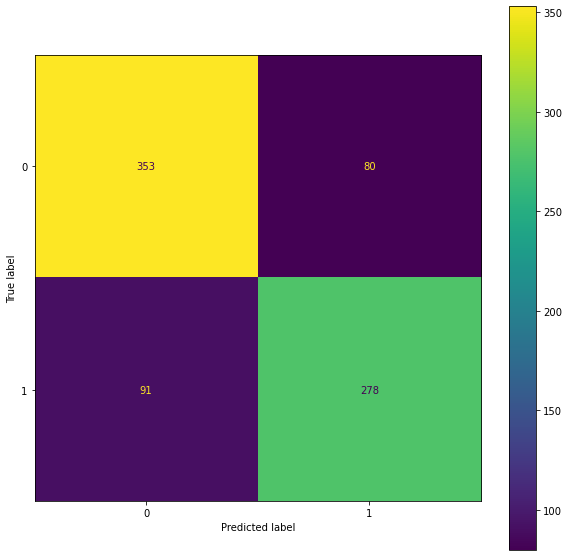

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(optimized_clf, X_test, Y_test, ax=ax)
plt.show()

* Le meilleur modèle : SVM avec un radial basis function kernel (rbf) **99% training accurcy / 80% test accuracy**, il a encore des problèmes quant à la généralisation (model is overfitting). 
<br>
* A rappeler , on a pas encore pris en compte les informations apportées par l'angle d'incidence.

On essaie d'exploiter l'information donnée par l'angle d'incidence


In [53]:
new_data = get_data()
df2_=new_data.iloc[:,[1,3,4]]
df3_=new_data.iloc[:,[2,3,4]]
df2_.rename(columns={"band_1": "image"}, inplace=True)
df3_.rename(columns={"band_2": "image"}, inplace=True)
df_=pd.concat([df2_,df3_], ignore_index=True)
df_=df_.sample(frac=1).reset_index(drop=True)
df_

,image,inc_angle,is_iceberg
0,"[-24.756645, -28.033722, -28.033661, -25.26754...",na,0
1,"[-17.992577, -17.88339, -17.883461, -17.992788...",na,0
2,"[-26.72291, -27.418192, -27.787899, -25.774536...",44.624,1
3,"[-26.403044, -25.243254, -22.676935, -22.88136...",40.7129,1
4,"[-27.32061, -28.015911, -28.015911, -28.015968...",37.6877,1
...,...,...,...
3203,"[-20.029573, -20.029573, -24.320618, -28.59826...",39.9844,1
3204,"[-28.97525, -24.94241, -24.942476, -27.196629,...",36.1061,1
3205,"[-18.494432, -21.417046, -24.032461, -21.07648...",40.3958,1
3206,"[-28.378256, -29.651638, -32.304195, -27.62257...",42.1486,1


In [54]:
df_.drop(df_.loc[(df_["inc_angle"]=='na')].index, inplace=True)
df_.reset_index()
df_

,image,inc_angle,is_iceberg
2,"[-26.72291, -27.418192, -27.787899, -25.774536...",44.624,1
3,"[-26.403044, -25.243254, -22.676935, -22.88136...",40.7129,1
4,"[-27.32061, -28.015911, -28.015911, -28.015968...",37.6877,1
5,"[-11.146492, -15.065062, -14.514702, -13.85475...",38.0165,0
6,"[-29.889511, -24.62472, -23.399364, -23.869026...",45.149,0
...,...,...,...
3203,"[-20.029573, -20.029573, -24.320618, -28.59826...",39.9844,1
3204,"[-28.97525, -24.94241, -24.942476, -27.196629,...",36.1061,1
3205,"[-18.494432, -21.417046, -24.032461, -21.07648...",40.3958,1
3206,"[-28.378256, -29.651638, -32.304195, -27.62257...",42.1486,1


In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_["inc_angle"]=scaler.fit_transform(np.array(df_["inc_angle"]).reshape(-1,1))
df_



,image,inc_angle,is_iceberg
2,"[-26.72291, -27.418192, -27.787899, -25.774536...",1.395175,1
3,"[-26.403044, -25.243254, -22.676935, -22.88136...",0.376245,1
4,"[-27.32061, -28.015911, -28.015911, -28.015968...",-0.411888,1
5,"[-11.146492, -15.065062, -14.514702, -13.85475...",-0.326228,0
6,"[-29.889511, -24.62472, -23.399364, -23.869026...",1.531949,0
...,...,...,...
3203,"[-20.029573, -20.029573, -24.320618, -28.59826...",0.186454,1
3204,"[-28.97525, -24.94241, -24.942476, -27.196629,...",-0.823931,1
3205,"[-18.494432, -21.417046, -24.032461, -21.07648...",0.293633,1
3206,"[-28.378256, -29.651638, -32.304195, -27.62257...",0.750277,1


In [56]:
df_["image"]=df_["image"].apply(normalise_image)
df_

,image,inc_angle,is_iceberg
2,"[0.48422235135053454, 0.45779038141069317, 0.4...",1.395175,1
3,"[0.27147777838084747, 0.31026340914053235, 0.3...",0.376245,1
4,"[0.6195711193200599, 0.5857511102874601, 0.585...",-0.411888,1
5,"[0.3752469348780625, 0.26536371830647204, 0.28...",-0.326228,0
6,"[0.10410893622058526, 0.21141299022065602, 0.2...",1.531949,0
...,...,...,...
3203,"[0.39233628909098783, 0.39233628909098783, 0.2...",0.186454,1
3204,"[0.2588554989568069, 0.4569732807945856, 0.456...",-0.823931,1
3205,"[0.4170772730250832, 0.3220004438589075, 0.236...",0.293633,1
3206,"[0.2776997161822557, 0.237469471070952, 0.1536...",0.750277,1


In [63]:
new_X = pd.DataFrame(df_["image"].to_list())
temp = df_["inc_angle"]
new_X

,0,1,2,3,4,5,6,7,8,9,...,5615,5616,5617,5618,5619,5620,5621,5622,5623,5624
0,0.484222,0.457790,0.443736,0.520276,0.508687,0.496677,0.413690,0.302584,0.457780,0.542289,...,0.443622,0.457674,0.443619,0.428939,0.484100,0.443615,0.323780,0.323779,0.428932,0.457662
1,0.271478,0.310263,0.396086,0.389249,0.301038,0.327868,0.402759,0.327865,0.249940,0.271464,...,0.260755,0.260755,0.238398,0.367565,0.336131,0.271312,0.352271,0.300875,0.319034,0.300872
2,0.619571,0.585751,0.585751,0.585748,0.487046,0.585743,0.619557,0.602984,0.585737,0.508705,...,0.585481,0.548717,0.439784,0.585473,0.585473,0.508441,0.463925,0.567483,0.693590,0.602705
3,0.375247,0.265364,0.280797,0.299303,0.267624,0.233807,0.265355,0.269866,0.346003,0.357183,...,0.347498,0.280653,0.280651,0.330689,0.271948,0.258285,0.238789,0.228421,0.280642,0.278495
4,0.104109,0.211413,0.236388,0.226815,0.071829,0.113677,0.139629,0.147498,0.147497,0.205959,...,0.131338,0.216638,0.249779,0.245407,0.154974,0.093926,0.139569,0.182261,0.175822,0.175821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,0.392336,0.392336,0.257616,0.123317,0.233885,0.368181,0.306063,0.306063,0.265080,0.242020,...,0.225341,0.207740,0.305910,0.299492,0.279282,0.207734,0.179001,0.198486,0.097160,0.233720
2938,0.258855,0.456973,0.456970,0.346232,0.330125,0.361747,0.196283,0.277804,0.196276,0.238979,...,0.313090,0.468681,0.468681,0.390881,0.468675,0.404866,0.431540,0.418407,0.418407,0.345907
2939,0.417077,0.322000,0.236917,0.333080,0.236914,0.321994,0.432769,0.417066,0.382772,0.451239,...,0.428804,0.378058,0.265793,0.316158,0.447517,0.500238,0.424896,0.408744,0.387162,0.395991
2940,0.277700,0.237469,0.153667,0.301574,0.312775,0.353502,0.264928,0.264927,0.264925,0.343868,...,0.289761,0.371670,0.371670,0.264794,0.190170,0.206805,0.277555,0.251399,0.362665,0.412696


In [64]:
len(temp)

2942

In [65]:
new_X_tr , new_X_test , new_Y_tr, new_Y_test = train_test_split(new_X, new_Y)


## Convolutional Neural Network

In [66]:
import torch 
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim


Architecture de notre CNN :

In [67]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.conv2=nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        self.conv3=nn.Conv2d(in_channels=12,out_channels=24,kernel_size=7)

        self.fc1=nn.Linear(in_features=24*4*4, out_features=240)
        self.fc2=nn.Linear(in_features=240, out_features=120)
        self.fc3=nn.Linear(in_features=120, out_features=60)
        self.out=nn.Linear(in_features=60, out_features=2)
        
    def forward(self, t):
        t=self.conv1(t)
        t=f.max_pool2d(f.relu(t),kernel_size=3, stride=2)
        t=self.conv2(t)
        t=f.max_pool2d(f.relu(t),kernel_size=3, stride=2)
        t=self.conv3(t)
        t=f.max_pool2d(f.relu(t),kernel_size=3, stride=2)

        t=t.reshape(-1,24*4*4)
        t=self.fc1(t)
        t=f.relu(t)

        t=self.fc2(t)
        t=f.relu(t)
        
        t=self.fc3(t)
        t=f.relu(t)

        t=self.out(t)
        return t
        

In [68]:
class dataset(Dataset):
    def __init__(self,data, transform=None,):
        self.data=data
        self.transform=transform

    def __getitem__(self, index):
        image=np.array(self.data.loc[index,["image"]][0]).reshape(75,75)
        label=self.data["is_iceberg"][index]
      
        if self.transform :
            image=self.transform(image)

        return image,label
    

    def __len__(self):
        return len(self.data)

On applique quelques opérations de data augmentation (augmenter le contraste, fliper les images...), puis on load les données dans Data loader de pytorch

In [69]:
train_set1=dataset(df.loc[0:2200,:],transform=transforms.ToTensor())
new_transforms=transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomRotation(degrees=60),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),    
])
train_set2=dataset(df.loc[0:1000,:],transform=new_transforms)
train_data=torch.utils.data.ConcatDataset([train_set1,train_set2])
train_data_loader=DataLoader(train_data, batch_size=8, shuffle=True)



Instanciation du modèle :

In [70]:
network=Network()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.0)

### Learning loop

In [ ]:
train_test= DataLoader(train_data, batch_size=3202)
images, labels=next(iter(train_test))
preds=network(images.float())
print(labels)
print(preds.argmax(dim=1))

### Training accuracy

In [ ]:
s=0
for i in range(3202):
    if labels[i]==preds.argmax(dim=1)[i]:
        s+=1
        
print("training accuracy : ", s/3202)

training accuracy :  0.9078700811992505


### Model test

In [ ]:
test_set=dataset(df.loc[2201:,:].reset_index(drop=True),transform=transforms.ToTensor())
test_loader=DataLoader(test_set, batch_size=1007)
img, lab=next(iter(test_loader))
prediction=network(img.float())
print(prediction.argmax(dim=1))

tensor([1, 1, 0,  ..., 0, 0, 0])


In [ ]:
crt=0
for i in range(1007):
   if prediction.argmax(dim=1)[i]==lab[i]:
        crt+=1
print(crt, " test accuracy : ", crt/1007)

827  test accuracy :  0.8212512413108243


In [ ]:

i=3200

img_test=torch.tensor(df["image"][i]).reshape(75,75)
img_test =torch.unsqueeze(img_test,0)
img_test =torch.unsqueeze(img_test,0)
estim=network(img_test.float())
print(estim)
print(df["is_iceberg"][i])
print(estim.argmax(dim=1))

tensor([[-2.4259,  2.8086]], grad_fn=<AddmmBackward>)
1
tensor([1])


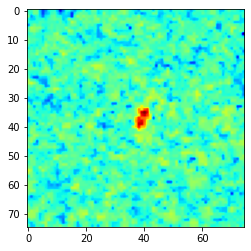

In [ ]:
plt.imshow(np.array(df["image"][i]).reshape(75,75),interpolation=None, cmap="jet")

### Le modele a confirmé qu il s'agit d'un iceberg